<a href="https://colab.research.google.com/github/anikch/paddy/blob/main/Code3_Paddy_ResNet50_exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.7 MB/s 


In [2]:
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394 kB 4.7 MB/s 


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from functools import partial
import posixpath
from keras import models, regularizers, layers, optimizers, losses, metrics
import keras_cv
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!nvidia-smi

Tue Oct 25 21:35:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    42W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
colab= '/content/drive/MyDrive'
local= r'G:\My Drive'

code_runtime= colab

In [7]:
tf.__version__

'2.9.2'

In [8]:
file1= 'thesis/dataset/paddy_doctor/train.csv'
inp_file = posixpath.join(code_runtime, file1)

train_table=pd.read_csv(inp_file)
train_table

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [9]:
labels=list(np.unique(train_table['label']))
labels

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [10]:
train_dir= 'thesis/dataset/paddy_doctor/train/'
val_dir= 'thesis/dataset/paddy_doctor/val/'
img_size= 224

train_files= posixpath.join(code_runtime, train_dir)
test_files= posixpath.join(code_runtime, val_dir)

train_data= tf.keras.utils.image_dataset_from_directory(train_files,
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        validation_split=0.2,
                                                        subset="training",
                                                        class_names=labels,
                                                        color_mode='rgb',
                                                        image_size=(img_size, img_size),
                                                        shuffle=True,
                                                        seed= 42,
                                                        batch_size= 16)

val_data= tf.keras.utils.image_dataset_from_directory(train_files,
                                                        labels= 'inferred',
                                                        label_mode='categorical',
                                                        validation_split=0.2,
                                                        subset="validation",
                                                        class_names= labels,
                                                        color_mode='rgb',
                                                        image_size=(img_size, img_size),
                                                        shuffle=True,
                                                        seed= 42,
                                                        batch_size= 16)


test_datagen= ImageDataGenerator()
test_data= test_datagen.flow_from_directory(test_files,
                                            target_size= (img_size, img_size),
                                            batch_size= 16,
                                            shuffle = False, 
                                            class_mode='categorical')

Found 14302 files belonging to 10 classes.
Using 11442 files for training.
Found 14302 files belonging to 10 classes.
Using 2860 files for validation.
Found 1500 images belonging to 10 classes.


In [11]:
class_names = train_data.class_names
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


In [12]:
test_data.class_indices

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bacterial_panicle_blight': 2,
 'blast': 3,
 'brown_spot': 4,
 'dead_heart': 5,
 'downy_mildew': 6,
 'hispa': 7,
 'normal': 8,
 'tungro': 9}

## Augmentation Pipeline

In [29]:
# data augmentation
def augment_train_data(images, labels):
  inputs= {"images": images, "labels": labels}
  layers= keras_cv.layers.RandAugment.get_standard_policy(value_range=(0, 255), geometric= True, magnitude= 0.5, magnitude_stddev= 0.2)
  layers= layers[1:3] + layers[8:] + [keras_cv.layers.preprocessing.RandomFlip(mode= 'horizontal'),
                         keras_cv.layers.preprocessing.RandomRotation(0.2),
                    keras_cv.layers.preprocessing.RandomRotation(factor= .1, seed= 42),
                    keras_cv.layers.GridMask(ratio_factor= (.0, .3), rotation_factor= (.0,.1), fill_mode= 'gaussian_noise'), 
                    #keras_cv.layers.RandomColorJitter(brightness_factor= .5, contrast_factor= .5, hue_factor= .2, saturation_factor= (.1, .9), value_range= [0, 255])
                    ]
  aug_pipeline= keras_cv.layers.RandomAugmentationPipeline(layers= layers, augmentations_per_image= 3, rate= .5)
  outputs= aug_pipeline(inputs)
  print(*layers)
  return outputs['images'], outputs['labels']

In [30]:
AUTOTUNE= tf.data.AUTOTUNE
train_aug_ds= train_data.map(augment_train_data, num_parallel_calls= tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds= val_data.prefetch(buffer_size= AUTOTUNE)

<keras_cv.layers.preprocessing.equalization.Equalization object at 0x7fdc05fb01d0> <keras_cv.layers.preprocessing.solarization.Solarization object at 0x7fdc05b39950> <keras.layers.preprocessing.image_preprocessing.RandomTranslation object at 0x7fdc0513a690> <keras.layers.preprocessing.image_preprocessing.RandomTranslation object at 0x7fdc0511a250> <keras_cv.layers.preprocessing.random_flip.RandomFlip object at 0x7fdc05fade90> <keras_cv.layers.preprocessing.random_rotation.RandomRotation object at 0x7fdc0511bc90> <keras_cv.layers.preprocessing.random_rotation.RandomRotation object at 0x7fdc05fadf90> <keras_cv.layers.preprocessing.grid_mask.GridMask object at 0x7fdc0510fa10>


## VGG16 (Augmentation + Transfer Learning + Fine Tune)

In [31]:
base_model= tf.keras.applications.resnet50.ResNet50(
    include_top= False,
    weights= 'imagenet',
    input_shape=(img_size, img_size, 3),
    pooling= 'max'
)

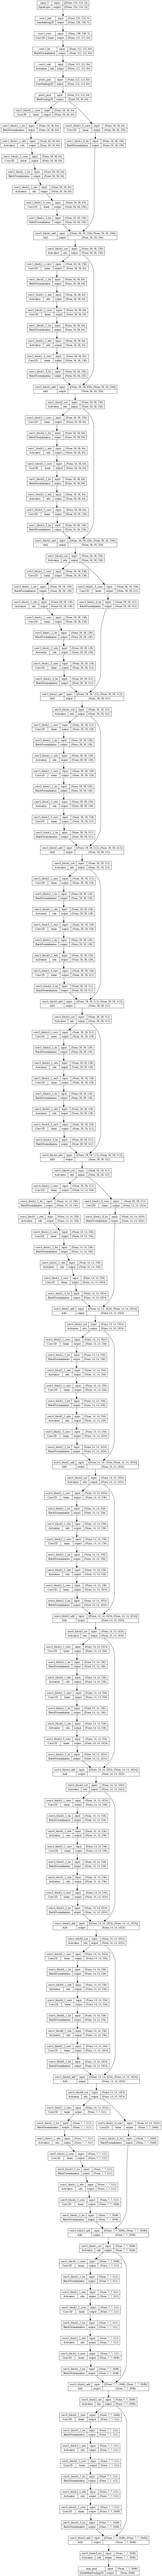

In [32]:
tf.keras.utils.plot_model(
    base_model,
    show_shapes= True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TR",
    expand_nested=False,
    dpi=72,
    layer_range=None,
    show_layer_activations=True,
)

In [33]:
inputs= tf.keras.Input(shape= (img_size, img_size, 3))
preprocess_layer= tf.keras.applications.resnet50.preprocess_input(inputs)
normalization_layer= tf.keras.layers.Rescaling(scale= 1./127.5, offset= -1)(preprocess_layer)
x= base_model(normalization_layer)
x= tf.keras.layers.Dropout(0.2)(x)
outputs= tf.keras.layers.Dense(10, activation= 'softmax')(x)

In [34]:
model= tf.keras.Model(inputs= inputs, outputs= outputs, name= "ResNet50_TL_augmentation")

In [35]:
model.summary()

Model: "ResNet50_TL_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_1 (Dropout)         (None, 2048) 

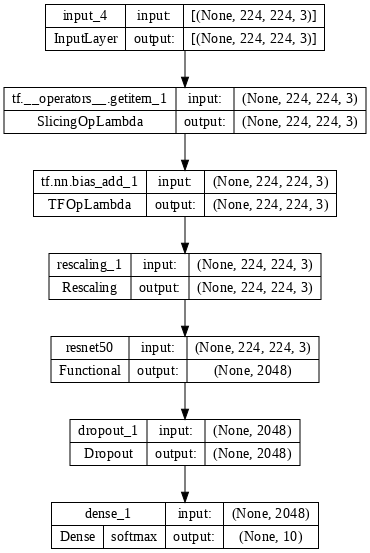

In [36]:
tf.keras.utils.plot_model(
    model,
    show_shapes= True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TR",
    expand_nested=False,
    dpi=72,
    layer_range=None,
    show_layer_activations=True,
)

In [37]:
%%time
n_epochs= 100

filepath= "weights-improvement-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint_callback= ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, save_best_only= True, mode= 'max')
early_stop_callback= EarlyStopping(monitor='val_accuracy', patience= 10, verbose= 1, mode='max', restore_best_weights= True)
callbacks_list=[checkpoint_callback, early_stop_callback]

CPU times: user 107 µs, sys: 19 µs, total: 126 µs
Wall time: 132 µs


In [38]:
optimizer_adam_amsgrad= tf.keras.optimizers.Adam(learning_rate= 1e-4, amsgrad= True)
optimizer_adam= tf.keras.optimizers.Adam(learning_rate= 1e-4, amsgrad= False)
optimizer_sgd= tf.keras.optimizers.SGD(learning_rate= 1e-4, momentum= 0.9)

In [39]:
model.compile(
        optimizer = optimizer_adam_amsgrad,
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy', tfa.metrics.F1Score(average='macro', num_classes= 10)]
        )

In [40]:
history= model.fit(train_aug_ds,
                  epochs= n_epochs,
                  validation_data= val_ds,
                  callbacks= callbacks_list,
                  verbose= 1)

Epoch 1/100
716/716 [==============================] - ETA: 0s - loss: 2.8283 - accuracy: 0.5838 - f1_score: 0.5828
Epoch 1: val_accuracy improved from -inf to 0.15035, saving model to weights-improvement-01-0.1503.hdf5
716/716 [==============================] - 280s 383ms/step - loss: 2.8283 - accuracy: 0.5838 - f1_score: 0.5828 - val_loss: 11.0458 - val_accuracy: 0.1503 - val_f1_score: 0.0955
Epoch 2/100
716/716 [==============================] - ETA: 0s - loss: 0.6199 - accuracy: 0.8616 - f1_score: 0.8612
Epoch 2: val_accuracy improved from 0.15035 to 0.87133, saving model to weights-improvement-02-0.8713.hdf5
716/716 [==============================] - 40s 55ms/step - loss: 0.6199 - accuracy: 0.8616 - f1_score: 0.8612 - val_loss: 0.7280 - val_accuracy: 0.8713 - val_f1_score: 0.8668
Epoch 3/100
715/716 [============================>.] - ETA: 0s - loss: 0.2849 - accuracy: 0.9255 - f1_score: 0.9252
Epoch 3: val_accuracy improved from 0.87133 to 0.90420, saving model to weights-improvem

In [41]:
model.evaluate(test_data, batch_size= 16, return_dict= True)

94/94 [==============================] - 322s 3s/step - loss: 0.3896 - accuracy: 0.9373 - f1_score: 0.9370


{'loss': 0.38964998722076416,
 'accuracy': 0.937333345413208,
 'f1_score': 0.9369600415229797}

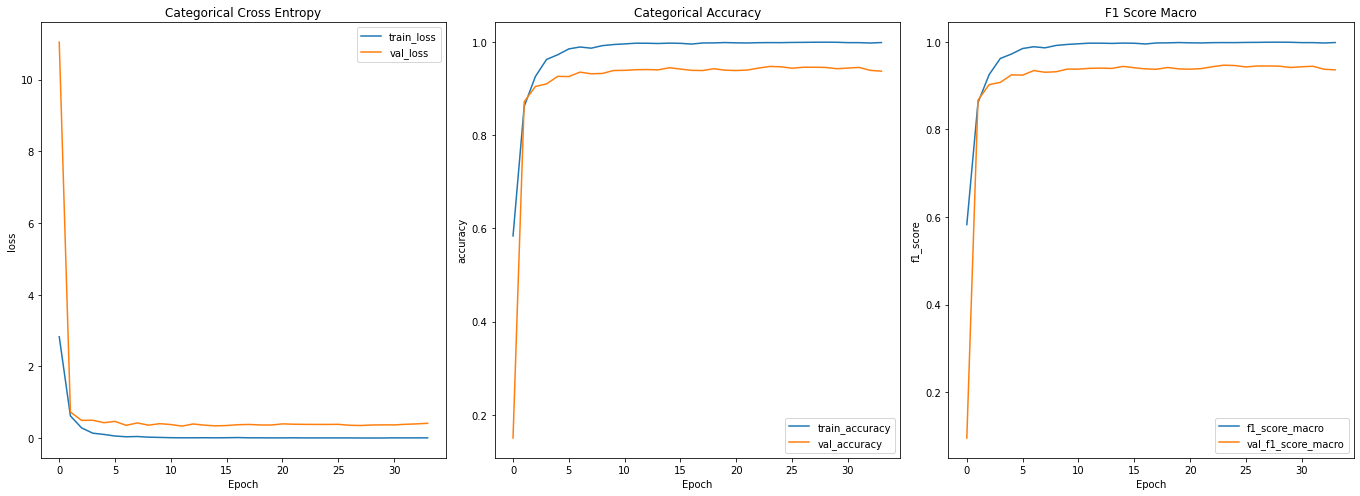

In [43]:
def plot_results(history, epochs, FE_name= "ResNet50", model_name= "ResNet50_model", version= 1):
    import os
    ## Create the dataframe
    data = pd.DataFrame()
    data["Epoch"] = [i for i in range(epochs)]
    data["loss"] = history.history["loss"]
    data["val_loss"] = history.history["val_loss"]
    data["accuracy"] = history.history["accuracy"]
    data["val_accuracy"] = history.history["val_accuracy"]
    data["f1_score"] = history.history["f1_score"]
    data["val_f1_score"] = history.history["val_f1_score"]

    ## Create subplots
    fig, ax= plt.subplots(1, 3, figsize = (19, 7))

    ## plot loss
    sns.lineplot(x= "Epoch", y= "loss", data = data, ax= ax[0])
    sns.lineplot(x= "Epoch", y= "val_loss", data = data, ax= ax[0])
    ax[0].legend(["train_loss", "val_loss"], loc= 'best')
    ax[0].title.set_text("Categorical Cross Entropy")

    ## plot accuracy
    sns.lineplot(x = "Epoch", y = "accuracy", data = data, ax = ax[1])
    sns.lineplot(x = "Epoch", y = "val_accuracy", data = data, ax = ax[1])
    ax[1].legend(["train_accuracy", "val_accuracy"], loc='best')
    ax[1].title.set_text("Categorical Accuracy")

    ## plot f1
    sns.lineplot(x = "Epoch", y = "f1_score", data = data, ax = ax[2])
    sns.lineplot(x = "Epoch", y = "val_f1_score", data = data, ax = ax[2])
    ax[2].legend(["f1_score_macro", "val_f1_score_macro"], loc='best')
    ax[2].title.set_text("F1 Score Macro")


    ## Remove padding
    fig.tight_layout()

plot_results(history, epochs = 34, FE_name = "ResNet50", model_name = "resnet50_transfer_learning")

In [44]:
tf.keras.models.save_model(model, '/content/drive/MyDrive/thesis/dataset/paddy_doctor/Code3_Paddy_ResNet50_exp1')

In [45]:
# Generating Confusion Matrix and Classification Report
Y_pred= model.predict_generator(test_data, 1500// 16 + 1)
y_pred= np.argmax(Y_pred, axis= 1)
print('Confusion Matrix')
conf_matrix= confusion_matrix(test_data.classes, y_pred)
conf_mat = np.array2string(conf_matrix)
#print(conf_matrix)
#print("=============================================================================================")
print('Classification Report')
target_names= test_data.class_indices
class_rep_vgg = classification_report(test_data.classes, y_pred, target_names=target_names)
print(class_rep_vgg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
Classification Report
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.96      0.85      0.90       150
   bacterial_leaf_streak       0.94      0.97      0.95       150
bacterial_panicle_blight       0.97      0.96      0.96       150
                   blast       0.91      0.95      0.93       150
              brown_spot       0.91      0.89      0.90       150
              dead_heart       0.96      0.99      0.98       150
            downy_mildew       0.95      0.88      0.91       150
                   hispa       0.96      0.94      0.95       150
                  normal       0.92      0.97      0.94       150
                  tungro       0.92      0.96      0.94       150

                accuracy                           0.94      1500
               macro avg       0.94      0.94      0.94      1500
            weighted avg       0.94      0.94      0.94      1500



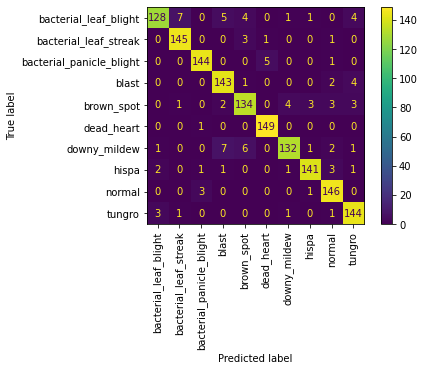

In [46]:
ConfusionMatrixDisplay.from_predictions(test_data.classes, y_pred, display_labels= target_names, xticks_rotation= 'vertical')